# **DATA PREPROCESSING**

**importing packages**

In [ ]:
import pandas as pd
import numpy as np
import os
import json

In [ ]:
from bs4 import BeautifulSoup as bs
import glob
import os
import re
import nltk
from nltk.tokenize import word_tokenize
from nltk.corpus import stopwords
from nltk.corpus import wordnet as wn
from nltk.stem import PorterStemmer
from nltk.stem import WordNetLemmatizer 
from sklearn.feature_extraction.text import TfidfVectorizer
import numpy as np
import pandas as pd

In [ ]:
nltk.download('punkt')
nltk.download('stopwords')

[nltk_data] Downloading package punkt to /root/nltk_data...
[nltk_data]   Unzipping tokenizers/punkt.zip.
[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Unzipping corpora/stopwords.zip.


True

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


**unzipping the dataset**

In [ ]:
!tar -xf /content/drive/MyDrive/IR_project/semeval2017-task8-dataset.tar.bz2

In [ ]:
!wget -c "https://s3.amazonaws.com/dl4j-distribution/GoogleNews-vectors-negative300.bin.gz"

--2021-04-18 10:27:43--  https://s3.amazonaws.com/dl4j-distribution/GoogleNews-vectors-negative300.bin.gz
Resolving s3.amazonaws.com (s3.amazonaws.com)... 52.217.201.136
Connecting to s3.amazonaws.com (s3.amazonaws.com)|52.217.201.136|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 1647046227 (1.5G) [application/x-gzip]
Saving to: ‘GoogleNews-vectors-negative300.bin.gz’

GoogleNews-vectors- 100%[===================>]   1.53G  40.9MB/s    in 50s     

2021-04-18 10:28:33 (31.6 MB/s) - ‘GoogleNews-vectors-negative300.bin.gz’ saved [1647046227/1647046227]



In [ ]:
!gzip -d /content/GoogleNews-vectors-negative300.bin.gz

**using gensim to get the pretrained w2v model**

In [ ]:
import gensim
from gensim.models import KeyedVectors
# Load vectors directly from the file
model = KeyedVectors.load_word2vec_format('/content/GoogleNews-vectors-negative300.bin', binary=True)

In [ ]:
import pickle
pickling_on = open("/content/drive/MyDrive/IR_project/w2v_google.pickle","wb")
pickle.dump(model, pickling_on)
pickling_on.close()

In [ ]:
import pickle
pickling_on = open("/content/drive/MyDrive/IR_project/w2v_google.pickle","rb")
model = pickle.load(pickling_on)
pickling_on.close()

In [ ]:
class extract():
  def removePunctAndNumbers(self,xmlfile):
    res = re.sub(r'[^\w\s]', ' ', str(xmlfile) )
    res = re.sub("\d+", " ", res)
    return res
  def lowercasing(self,tokenise2):
    lower_text = [word.lower() for word in tokenise2]
    return lower_text
  def stopword(self,lower_text):
    ext = lower_text.split()
    stopword = stopwords.words('english')
    extract=[i for i in ext if i not in stopword] 
    return " ".join(extract)

In [ ]:
f = extract()

**creating function to find cosine similarity values**

In [ ]:
from sklearn.metrics.pairwise import cosine_similarity
f=extract()
def extract_text(x):
  x=str(x).replace('\n',' ')
  x=f.removePunctAndNumbers(x).lower().strip()
  x=f.stopword(x)
  return x
tweets={}
path="/content/semeval2017-task8-dataset/rumoureval-data"
def list_doc(path):
  count = 0
  count2 = 0
  for news in os.listdir(path):
    for tweet in os.listdir(path+'/'+str(news)):
      x=tweet
      for n_file in os.listdir(path+'/'+'/'+str(news)+'/'+str(tweet)+'/'+'source-tweet'):

        with open(path+'/'+'/'+str(news)+'/'+str(tweet)+'/'+'source-tweet'+'/'+str(n_file)) as f:
          
          t = json.load(f)
          tweets[x]=t['text']
  return tweets
source_tweets=list_doc(path)
for source in list(source_tweets.keys()):
  source_tweets[source]=extract_text(source_tweets[source])
replies={}
replytexts={}

def list_replies(path):
  count = 0
  count2 = 0
  
  for news in os.listdir(path):
    for tweet in os.listdir(path+'/'+str(news)):
      x=tweet
      y=[]
      reply_text=[]
      for n_file in os.listdir(path+'/'+'/'+str(news)+'/'+str(tweet)+'/'+'replies'):
        # 
          y.append(n_file[:len(n_file)-5])
          with open(path+'/'+'/'+str(news)+'/'+str(tweet)+'/'+'replies'+'/'+str(n_file)) as f:
            t = json.load(f)
            reply_text.append(t['text'])
      replies[x]=y
      replytexts[x]=reply_text
  print(count,count2)
  return replies,replytexts
reply_tweets,_=list_replies(path)
_,reply_texts=list_replies(path)
replies_processed = {}
for source in list(reply_texts.keys()):
  replies_processed[source]=[]
for source in list(reply_texts.keys()):
  for reply in reply_texts[source]:
     replies_processed[source].append(extract_text(reply))
def w2v_tweets_replies(tweets):
  reply_vecs={}
  for source in list(tweets.keys()):
    reply_vecs[source]=[]
  for source in list(tweets.keys()): 
    for reply in reply_texts[source]:
      vectors = []
      for x in reply.split(' '):
        try:
          vectors.append(model[x])
        except:
          vectors.append(np.zeros(300))
      reply_vecs[source].append(np.mean(np.array(vectors),axis=0))
  return reply_vecs
def w2v_tweets_sources(tweets):
  source_vecs={}
  for source in tweets.keys():
    vectors = []
    for x in tweets[source].split(' '):
      try:
        vectors.append(model[x])
      except:
        vectors.append(np.zeros(300))
    source_vecs[source]=np.mean(np.array(vectors),axis=0)
  return source_vecs
w2v_sources = w2v_tweets_sources(source_tweets)
w2v_replies = w2v_tweets_replies(replies_processed)
def LstmInput(sources, replies):
  embedding_Mat=[]
  cosine_sim_source = {}
  cosine_sim_reply = {}
  for source in sources.keys():
    temp1 = []
    temp1.append(list(sources[source]))
    temp2 = [0]
    temp3 = [0]
    source_n = [list(sources[source])]
    count = 0
    for reply in replies[source]:
      temp1.append(list(reply))
      temp2.append(cosine_similarity(source_n,[list(reply)])[0][0])
      temp3.append(cosine_similarity([temp1[count]],[list(reply)])[0][0])
      count+=1
    embedding_Mat.append(temp1)
    cosine_sim_source[source] = temp2
    cosine_sim_reply[source] = temp3
  return embedding_Mat,cosine_sim_source,cosine_sim_reply
final_input,css,csr = LstmInput(w2v_sources, w2v_replies)

In [ ]:
path="/content/semeval2017-task8-dataset/rumoureval-data"
class embeddings(extract):
  def __init__(self,path,num):
    self.path = path
    self.num = num

  def extract_text(self,x):
    x=str(x).replace('\n',' ')
    x=self.removePunctAndNumbers(x).lower().strip()
    x=self.stopword(x)
    return x
  def extract_full_text(self,x):
    x=str(x).replace('\n',' ')
    x=self.removePunctAndNumbers(x).lower().strip()
    return x
  def list_doc(self):
    tweets={}
    image_d={}
    url_d={}
    path = self.path
    count = 0
    count2 = 0
    for news in os.listdir(path):
      for tweet in os.listdir(path+'/'+str(news)):
        x=tweet
        for n_file in os.listdir(path+'/'+'/'+str(news)+'/'+str(tweet)+'/'+'source-tweet'):
          with open(path+'/'+'/'+str(news)+'/'+str(tweet)+'/'+'source-tweet'+'/'+str(n_file)) as f:
            t = json.load(f)
            tweets[x]=t['text']
            try:
              if t['entities']['media'][0]['type']=='photo':
                image_d[x] = 1
            except:
              image_d[x] = 0
            try:
              if t['entities']['urls']!=[]:
                url_d[x] = 1
              else:
                url_d[x] = 0
            except:
                url_d[x] = 0
    return tweets,image_d,url_d
  def list_replies(self):
    replies={}
    replytexts={} 
    image_d={}
    url_d={}
    path = self.path    
    for news in os.listdir(path):
      for tweet in os.listdir(path+'/'+str(news)):
        x = tweet
        y = []
        img_info = []
        url_info = []
        reply_text=[]
        for n_file in os.listdir(path+'/'+'/'+str(news)+'/'+str(tweet)+'/'+'replies'):
          # 
            y.append(n_file[:len(n_file)-5])
            with open(path+'/'+'/'+str(news)+'/'+str(tweet)+'/'+'replies'+'/'+str(n_file)) as f:
              t = json.load(f)
              reply_text.append(t['text'])
              try:
               if t['entities']['media'][0]['type']=='photo':
                 img_info.append(1)
              except:
                img_info.append(0)
              try:
                if t['entities']['urls']!=[]:
                  url_info.append(1)
              except:
                url_info.append(0)
        image_d[x]=img_info
        url_d[x]=url_info
        replies[x]=y
        replytexts[x]=reply_text
    return replies,replytexts,image_d,url_d
  def word2vec(self,model):
    reply_vecs = {}
    source_processed = {}
    _, reply_texts,_,_ = self.list_replies()
    source_tweets,_,_ = self.list_doc()
    for source in reply_texts.keys():
      if reply_texts[source]==[]:
        reply_texts[source] = ['jwnfiowanvo vvgguuh']
    # print(len(reply_texts.keys()))
    for source in list(source_tweets.keys()):
      source_processed[source] = self.extract_text(source_tweets[source])
    replies_processed = {}
    # print(len(source_processed.keys()))
    for source in list(reply_texts.keys()):
      replies_processed[source]=[]
    for source in list(reply_texts.keys()):
      for reply in reply_texts[source]:
        replies_processed[source].append(self.extract_text(reply))
    for source in list(reply_texts.keys()):
      reply_vecs[source]=[]
    source_vecs={}
    for source in source_processed.keys():
      vectors = []
      for x in source_processed[source].split(' '):
        embeddings = np.zeros(self.num)
        try:
          embeddings[:300] = model[x] 
          vectors.append(embeddings)
        except:
          vectors.append(embeddings)
      source_vecs[source]=np.mean(np.array(vectors),axis=0)
    for source in list(replies_processed.keys()):
      for reply in reply_texts[source]:
        vectors = []
        for x in reply.split(' '):
          embeddings = np.zeros(self.num)
          try:
            embeddings[:300] = model[x] 
            vectors.append(embeddings)           
          except:
            vectors.append(embeddings)
        reply_vecs[source].append(np.mean(np.array(vectors),axis=0))
    return reply_vecs ,source_vecs
  def swear_negation(self,reply_vecs,source_vecs,swear_words,negation_words):
    source_tweets,_,_ = self.list_doc()
    _, reply_texts,_,_ = self.list_replies()
    for source in list(source_vecs.keys()):
      count_s = 0
      count_n = 0
      for word in source_tweets[source].split():
        if word in swear_words:
          count_s+=1
        if word in negation_words:
          count_n+=1
      source_vecs[source][300]=count_s
      source_vecs[source][301]=count_n
    for source in list(reply_vecs.keys()):
      k=0
      for reply,vecs in zip(reply_texts[source],reply_vecs[source]):
        count_s = 0
        count_n = 0
        for word in reply.split():
          if word in swear_words:
            count_s+=1
          if word in negation_words:
            count_n+=1
        vecs[300]=count_s
        vecs[301]=count_n
        reply_vecs[source][k]=vecs
        k+=1
    return reply_vecs ,source_vecs
  def puncts(self,reply_vecs ,source_vecs):
    source_tweets,_,_ = self.list_doc()
    _, reply_texts,_,_ = self.list_replies()
    for source in source_tweets.keys():
      t = source_tweets[source]
      M = 0
      M1 = 0
      count_p = 0
      count_e = 0
      count_q = 0
      for chara in t:
        if chara=='.':
           source_vecs[source][302]=1
        elif chara=='!':
           source_vecs[source][303]=1
        elif chara=='?':
           source_vecs[source][304]=1      
        if chara in 'ABCDEFGHIJKLMNOPQRSTUVWXYZ':
            M+=1
        M1+=1
        source_vecs[source][305] = M/M1
    for source in reply_texts.keys():
      k=0
      for reply,vecs in zip(reply_texts[source],reply_vecs[source]):
        t = reply
        M=0
        M1=0
        count_p = 0
        count_e = 0
        count_q = 0
        for chara in t:
          if chara=='.':
            vecs[302]=1
          elif chara=='!':
            vecs[303]=1
          elif chara=='?':
            vecs[304]=1      
          if chara in 'ABCDEFGHIJKLMNOPQRSTUVWXYZ':
            M+=1
          if chara!=' ':
            M1+=1
        vecs[305] = M/M1
        reply_vecs[source][k]=vecs
        k+=1   
    return reply_vecs,source_vecs
  def url_images(self,reply_vecs,source_vecs):
    _,_,reply_image_d,reply_url_d = self.list_replies()
    _,source_image_d,source_url_d = self.list_doc()
    for source in reply_image_d.keys():
      if reply_image_d[source]==[]:
        reply_image_d[source] = [0]
      if reply_url_d[source]==[]:
        reply_url_d[source] = [0]
    for source in source_vecs.keys():
      if source_image_d[source] == 1:
        source_vecs[source][306] = 1
      else:
        source_vecs[source][306] = 0
      if source_url_d[source] == 1:
        source_vecs[source][307] = 1
      else:
        source_vecs[source][307] = 0
    for source in reply_vecs.keys():
      k=0
      for reply,val1,val2 in zip(reply_vecs[source],reply_image_d[source],reply_url_d[source]):
        if val1==1:
          if val2==0:
            reply[306] = 1
            reply[307] = 0
          else:
            reply[306] = 1
            reply[307] = 1           
        else:
          if val2==1:
            reply[306] = 0
            reply[307] = 1
          else:
            reply[306] = 0
            reply[307] = 0           
        reply_vecs[source][k]=reply
        k+=1         
    return reply_vecs,source_vecs
  def similarity(self,reply_vecs,css,csr):
    for source in reply_vecs.keys():
      k=0
      for reply,val1,val2 in zip(reply_vecs[source],css[source][1:],csr[source][1:]):
        reply[308]=val1
        reply[309]=val2
        reply_vecs[source][k]=reply
        k+=1         
    return reply_vecs   
  def word_char(self,reply_vecs,source_vecs):
    source_tweets,_,_ = self.list_doc()
    _, reply_texts,_,_ = self.list_replies()
    for source in source_tweets.keys():
      count_w = 0
      count_c = 0
      for word in self.extract_full_text(source_tweets[source]).split():
        count_w+=1
        count_c+=len(word)
      source_vecs[source][310] = count_w
      source_vecs[source][311] = count_c
    for source in reply_texts.keys():
      k = 0
      for reply,vecs in zip(reply_texts[source],reply_vecs[source]):
        count_w1 = 0
        count_c1 = 0
        for word in self.extract_full_text(reply).split():
          count_w1+=1
          count_c1+=len(word)
        vecs[310] = count_w1
        vecs[311] = count_c1
        reply_vecs[source][k]=vecs
        k+=1
    return reply_vecs, source_vecs
  def source_or_not(self,source_vecs):
    for source in source_vecs.keys():
      source_vecs[source][312] = 1
    return source_vecs

**defining object for feature extraction class**

In [ ]:
X = embeddings(path,313)

**300 dimensional embeddings**

In [ ]:
y,x = X.word2vec(model)

**negation words and swear words**

In [ ]:
negation_words = [ 'not', 'no', 'nobody', 'nothing','none', 'never', 'neither', 'nor', 'nowhere', 'hardly', 'scarcely', 'barely',
'don’t', 'isn’t', 'wasn’t', 'shouldn’t', 'wouldn’t', 'couldn’t', 'doesn’t']
swear_words = ["4r5e", "5h1t", "5hit", "a55", "anal", "anus", "ar5e", "arrse", "arse", "ass", "ass-fucker", "asses", "assfucker", 
                  "assfukka", "asshole", "assholes", "asswhole", "a_s_s", "b!tch", "b00bs", "b17ch", "b1tch", "ballbag", "balls", 
                  "ballsack", "bastard", "beastial", "beastiality", "bellend", "bestial", "bestiality", "bi+ch", "biatch", "bitch", 
                  "bitcher", "bitchers", "bitches", "bitchin", "bitching", "bloody", "blow job", "blowjob", "blowjobs", "boiolas", 
                  "bollock", "bollok", "boner", "boob", "boobs", "booobs", "boooobs", "booooobs", "booooooobs", "breasts", "buceta", 
                  "bugger", "bum", "bunny fucker", "butt", "butthole", "buttmuch", "buttplug", "c0ck", "c0cksucker", "carpet muncher", 
                  "cawk", "chink", "cipa", "cl1t", "clit", "clitoris", "clits", "cnut", "cock", "cock-sucker", "cockface", "cockhead", 
                  "cockmunch", "cockmuncher", "cocks", "cocksuck", "cocksucked", "cocksucker", "cocksucking", "cocksucks", "cocksuka", 
                  "cocksukka", "cok", "cokmuncher", "coksucka", "coon", "cox", "crap", "cum", "cummer", "cumming", "cums", "cumshot", 
                  "cunilingus", "cunillingus", "cunnilingus", "cunt", "cuntlick", "cuntlicker", "cuntlicking", "cunts", "cyalis", "cyberfuc", 
                  "cyberfuck", "cyberfucked", "cyberfucker", "cyberfuckers", "cyberfucking", "d1ck", "damn", "dick", "dickhead", "dildo", 
                  "dildos", "dink", "dinks", "dirsa", "dlck", "dog-fucker", "doggin", "dogging", "donkeyribber", "doosh", "duche", "dyke", 
                  "ejaculate", "ejaculated", "ejaculates", "ejaculating", "ejaculatings", "ejaculation", "ejakulate", "f u c k", "f u c k e r", 
                  "f4nny", "fag", "fagging", "faggitt", "faggot", "faggs", "fagot", "fagots", "fags", "fanny", "fannyflaps", "fannyfucker", 
                  "fanyy", "fatass", "fcuk", "fcuker", "fcuking", "feck", "fecker", "felching", "fellate", "fellatio", "fingerfuck", 
                  "fingerfucked", "fingerfucker", "fingerfuckers", "fingerfucking", "fingerfucks", "fistfuck", "fistfucked", "fistfucker", 
                  "fistfuckers", "fistfucking", "fistfuckings", "fistfucks", "flange", "fook", "fooker", "fuck", "fucka", "fucked", "fucker", 
                  "fuckers", "fuckhead", "fuckheads", "fuckin", "fucking", "fuckings", "fuckingshitmotherfucker", "fuckme", "fucks", "fuckwhit", 
                  "fuckwit", "fudge packer", "fudgepacker", "fuk", "fuker", "fukker", "fukkin", "fuks", "fukwhit", "fukwit", "fux", "fux0r", 
                  "f_u_c_k", "gangbang", "gangbanged", "gangbangs", "gaylord", "gaysex", "goatse", "God", "god-dam", "god-damned", "goddamn", 
                  "goddamned", "hardcoresex", "hell", "heshe", "hoar", "hoare", "hoer", "homo", "hore", "horniest", "horny", "hotsex", "jack-off", 
                  "jackoff", "jap", "jerk-off", "jism", "jiz", "jizm", "jizz", "kawk", "knob", "knobead", "knobed", "knobend", "knobhead", 
                  "knobjocky", "knobjokey", "kock", "kondum", "kondums", "kum", "kummer", "kumming", "kums", "kunilingus", "l3i+ch", "l3itch", 
                  "labia", "lust", "lusting", "m0f0", "m0fo", "m45terbate", "ma5terb8", "ma5terbate", "masochist", "master-bate", "masterb8", "masterbat*", 
                  "masterbat3", "masterbate", "masterbation", "masterbations", "masturbate", "mo-fo", "mof0", "mofo", "mothafuck", "mothafucka", "mothafuckas", 
                  "mothafuckaz", "mothafucked", "mothafucker", "mothafuckers", "mothafuckin", "mothafucking", "mothafuckings", "mothafucks", "mother fucker", "motherfuck", 
                  "motherfucked", "motherfucker", "motherfuckers", "motherfuckin", "motherfucking", "motherfuckings", "motherfuckka", "motherfucks", "muff", "mutha", "muthafecker",
                  "muthafuckker", "muther", "mutherfucker", "n1gga", "n1gger", "nazi", "nigg3r", "nigg4h", "nigga", "niggah", "niggas", "niggaz", "nigger", "niggers", "nob", 
                  "nob jokey", "nobhead", "nobjocky", "nobjokey", "numbnuts", "nutsack", "orgasim", "orgasims", "orgasm", "orgasms", "p0rn", "pawn", "pecker", 
                  "penis", "penisfucker", "phonesex", "phuck", "phuk", "phuked", "phuking", "phukked", "phukking", "phuks", "phuq", "pigfucker", "pimpis", "piss", "pissed", "pisser", 
                  "pissers", "pisses", "pissflaps", "pissin", "pissing", "pissoff", "poop", "porn", "porno", "pornography", "pornos", "prick", "pricks", "pron", "pube", 
                  "pusse", "pussi", "pussies", "pussy", "pussys", "rectum", "retard", "rimjaw", "rimming", "s hit", "s.o.b.", "sadist", "schlong", "screwing", "scroat", 
                  "scrote", "scrotum", "semen", "sex", "sh!+", "sh!t", "sh1t", "shag", "shagger", "shaggin", "shagging", "shemale", "shi+", "shit", "shitdick", "shite", 
                  "shited", "shitey", "shitfuck", "shitfull", "shithead", "shiting", "shitings", "shits", "shitted", "shitter", "shitters", "shitting", "shittings", 
                  "shitty", "skank", "slut", "sluts", "smegma", "smut", "snatch", "son-of-a-bitch", "spac", "spunk", "s_h_i_t", "t1tt1e5", "t1tties", "teets", "teez", 
                  "testical", "testicle", "tit", "titfuck", "tits", "titt", "tittie5", "tittiefucker", "titties", "tittyfuck", "tittywank", "titwank", "tosser", "turd", "tw4t", 
                  "twat", "twathead", "twatty", "twunt", "twunter", "v14gra", "v1gra", "vagina", "viagra", "vulva", "w00se", "wang", "wank", "wanker", "wanky", "whoar", "whore", 
                  "willies", "willy", "xrated", "xxx"];


In [ ]:
y1,x1 = X.swear_negation(y,x,swear_words,negation_words)

**presence of punctuations**

In [ ]:
y2,x2 = X.puncts(y1,x1)

**url and image data**

In [ ]:
y3,x3 = X.url_images(y2,x2)

**cosine similarity**

In [ ]:
y4 = X.similarity(y3,css,csr)

In [ ]:
x4 = x3

**count of words and characters**

In [ ]:
y5,x5 = X.word_char(y4,x4)

In [ ]:
y6 = y5

**source tweet or reply tweet**

In [ ]:
x6 = X.source_or_not(x5)

In [ ]:
with open("/content/semeval2017-task8-dataset/traindev/rumoureval-subtaskA-train.json") as f:
    data=json.load(f)

In [ ]:
with open("/content/semeval2017-task8-dataset/traindev/rumoureval-subtaskA-dev.json") as f:
    data_test = json.load(f)

In [ ]:
reply_id,_,_,_ = X.list_replies()

**train data**

In [ ]:
train_source = []
for source in reply_id.keys():
  if source in data.keys():
    train_source.append(source)
len(train_source)

272

**test data**

In [ ]:
test_source = []
for source in reply_id.keys():
  if source in data_test.keys():
    test_source.append(source)
len(test_source)

25

In [ ]:
stances = []
for source in reply_id.keys():
  try:
    temp = []
    temp.append(data[source])
    for reply in reply_id[source]:
      temp.append(data[reply])
    stances.append(temp)
  except:
    pass
stances

[['support',
  'comment',
  'support',
  'comment',
  'deny',
  'support',
  'comment',
  'deny',
  'deny'],
 ['support',
  'support',
  'comment',
  'comment',
  'comment',
  'comment',
  'query',
  'support',
  'deny',
  'comment',
  'comment',
  'comment',
  'deny',
  'comment',
  'comment',
  'comment',
  'comment',
  'comment',
  'deny',
  'comment',
  'comment',
  'comment',
  'comment',
  'comment',
  'comment'],
 ['support',
  'comment',
  'comment',
  'comment',
  'query',
  'comment',
  'comment',
  'comment',
  'comment'],
 ['support', 'comment', 'comment'],
 ['deny',
  'query',
  'comment',
  'comment',
  'comment',
  'comment',
  'comment',
  'comment',
  'comment',
  'query',
  'comment',
  'comment',
  'comment',
  'deny',
  'comment',
  'comment',
  'comment',
  'comment',
  'comment',
  'comment',
  'comment',
  'comment',
  'comment',
  'comment',
  'comment',
  'comment',
  'comment',
  'comment',
  'comment'],
 ['support',
  'comment',
  'query',
  'comment',
  'com

In [ ]:
stances_test = []
for source in reply_id.keys():
  try:
    temp = []
    temp.append(data_test[source])
    for reply in reply_id[source]:
      temp.append(data_test[reply])
    stances_test.append(temp)
  except:
    pass
stances_test

[['support'],
 ['support', 'query', 'comment'],
 ['support', 'comment'],
 ['support',
  'comment',
  'comment',
  'deny',
  'comment',
  'comment',
  'support',
  'comment',
  'comment',
  'support',
  'deny',
  'comment',
  'query',
  'comment',
  'comment',
  'deny',
  'comment'],
 ['support', 'query', 'comment'],
 ['support',
  'comment',
  'comment',
  'comment',
  'deny',
  'comment',
  'query',
  'comment',
  'comment',
  'comment',
  'comment'],
 ['support', 'comment', 'comment', 'comment', 'support', 'support'],
 ['support',
  'comment',
  'comment',
  'support',
  'comment',
  'query',
  'support',
  'comment',
  'comment',
  'query',
  'support',
  'support',
  'query',
  'query',
  'comment',
  'comment',
  'comment',
  'support'],
 ['support', 'support', 'comment', 'comment'],
 ['support',
  'comment',
  'comment',
  'comment',
  'support',
  'comment',
  'comment',
  'comment',
  'comment',
  'comment',
  'comment',
  'comment',
  'support',
  'comment',
  'comment',
  'co

**CREATING INPUT TRAIN AND TEST DATA**

In [ ]:
train_mat = []
stance_code = {'comment':0,'deny':1,'support':2,'query':3}
stances = []
for source in train_source:
  embeddings = []
  temp = []
  embeddings.append(list(x6[source]))
  temp.append(stance_code[data[source]])
  for reply,id in zip(y6[source],reply_id[source]):
    embeddings.append(list(reply))
    temp.append(stance_code[data[id]])
  train_mat.append(embeddings)
  stances.append(temp)

In [ ]:
test_mat = []
stance_code = {'comment':0,'deny':1,'support':2,'query':3}
stances_t = []
for source in test_source:
  embeddings = []
  temp = []
  embeddings.append(list(x6[source]))
  temp.append(stance_code[data_test[source]])
  for reply,id in zip(y6[source],reply_id[source]):
    embeddings.append(list(reply))
    temp.append(stance_code[data_test[id]])
  test_mat.append(embeddings)
  stances_t.append(temp)

In [ ]:
stances_t

[[2],
 [2, 3, 0],
 [2, 0],
 [2, 0, 0, 1, 0, 0, 2, 0, 0, 2, 1, 0, 3, 0, 0, 1, 0],
 [2, 3, 0],
 [2, 0, 0, 0, 1, 0, 3, 0, 0, 0, 0],
 [2, 0, 0, 0, 2, 2],
 [2, 0, 0, 2, 0, 3, 2, 0, 0, 3, 2, 2, 3, 3, 0, 0, 0, 2],
 [2, 2, 0, 0],
 [2, 0, 0, 0, 2, 0, 0, 0, 0, 0, 0, 0, 2, 0, 0, 0, 0, 0, 0, 0, 0, 2, 0, 0, 0],
 [2, 2, 3, 0, 0, 0, 2, 0, 3, 0, 0, 0, 2, 0, 0, 0, 0, 0, 0, 0, 0, 0],
 [2, 0, 3, 3],
 [2,
  0,
  2,
  2,
  0,
  0,
  2,
  0,
  0,
  0,
  2,
  0,
  2,
  0,
  2,
  2,
  0,
  0,
  0,
  0,
  0,
  2,
  0,
  0,
  2,
  2,
  2,
  2,
  2,
  2,
  1,
  2,
  0],
 [2, 0, 0, 2, 0, 0, 0, 3, 0, 0, 0],
 [2, 2, 2, 0],
 [2, 0, 0, 0],
 [2, 3, 2, 0, 0, 3, 0, 0, 0, 0],
 [0, 2, 0, 0, 2, 0, 0, 0, 2, 0],
 [2, 0, 3, 1, 3, 3, 1, 0, 0, 0, 0, 3, 0, 1],
 [2, 0, 2, 0, 0, 0, 0, 0, 0, 0],
 [1, 2, 1],
 [2, 0, 2],
 [2,
  0,
  0,
  3,
  0,
  0,
  0,
  0,
  0,
  3,
  3,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  2,
  0,
  1,
  3,
  0,
  0,
  0,
  3],


In [ ]:
import pickle
pickling_on = open("/content/drive/MyDrive/IR_project/LSTM_Input.pickle","wb")
pickle.dump(zip(train_mat,stances), pickling_on)
pickling_on.close()

In [ ]:
import pickle
pickling_on = open("/content/drive/MyDrive/IR_project/LSTM_Input.pickle","rb")
train_m = pickle.load(pickling_on)
pickling_on.close()

# **LSTM**

In [ ]:
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim

torch.manual_seed(1)

In [ ]:
train_mat_new = []
for vect in train_mat:
  train_mat_new.append(torch.FloatTensor(vect))

In [ ]:
train_mat_new[0]

tensor([[-4.5870e-02,  6.1365e-02, -3.6065e-02,  ...,  2.3000e+01,
          9.7000e+01,  1.0000e+00],
        [ 4.5697e-02,  1.2078e-02, -5.5903e-02,  ...,  2.2000e+01,
          1.0600e+02,  0.0000e+00],
        [ 4.3159e-02,  1.1407e-02, -5.2797e-02,  ...,  2.2000e+01,
          1.0500e+02,  0.0000e+00],
        ...,
        [ 0.0000e+00,  0.0000e+00,  0.0000e+00,  ...,  3.0000e+00,
          3.2000e+01,  0.0000e+00],
        [ 9.0321e-02,  2.7122e-02,  4.1493e-02,  ...,  1.2000e+01,
          6.1000e+01,  0.0000e+00],
        [ 2.0213e-02,  2.6523e-02,  2.8210e-02,  ...,  2.1000e+01,
          1.0000e+02,  0.0000e+00]])

In [ ]:
stances_new = []
for vect in stances:
  stances_new.append(torch.FloatTensor(vect))
stances_new

[tensor([2., 0., 2., 0., 1., 2., 0., 1., 1.]),
 tensor([2., 2., 0., 0., 0., 0., 3., 2., 1., 0., 0., 0., 1., 0., 0., 0., 0., 0.,
         1., 0., 0., 0., 0., 0., 0.]),
 tensor([2., 0., 0., 0., 3., 0., 0., 0., 0.]),
 tensor([2., 0., 0.]),
 tensor([1., 3., 0., 0., 0., 0., 0., 0., 0., 3., 0., 0., 0., 1., 0., 0., 0., 0.,
         0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.]),
 tensor([2., 0., 3., 0., 0., 0., 2., 3., 2., 0., 0., 0., 0., 0., 0., 0., 0., 2.,
         0., 0., 0., 0., 2.]),
 tensor([2., 0., 0., 0., 0., 0., 2., 3., 2., 0., 0.]),
 tensor([0., 0., 0., 3., 2., 0., 0., 0., 0., 0., 2., 0., 0., 1., 0., 3.]),
 tensor([2., 0., 0., 0., 2., 1., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 1.,
         0., 0., 0.]),
 tensor([2., 0., 0., 0., 0., 0., 0., 3.]),
 tensor([2., 0., 0., 0., 0., 0., 0., 0., 0., 2.]),
 tensor([2., 0., 2.]),
 tensor([2., 0., 0., 0., 2., 0., 0., 0., 0., 0., 2., 0., 0., 0., 0., 0., 0., 0.,
         0., 0., 0., 2.]),
 tensor([2., 2., 1., 2., 1., 1., 0., 0., 2., 2., 2., 0.,

**Dataset function customised for dataloader function**

In [ ]:
class Dataset():

    def __init__(self,zipped):
        # Initialize data, download, etc.
        # read with numpy or pandas
        trainList = list(zipped)

        Dataset, target = zip(*trainList)
        self.n_samples = len(Dataset)

        # here the first column is the class label, the rest are the features
        self.x_data = Dataset # size [n_samples, n_features]
        self.y_data = target # size [n_samples, 1]

    # support indexing such that dataset[i] can be used to get i-th sample
    def __getitem__(self, index):
        return self.x_data[index], self.y_data[index]

    # we can call len(dataset) to return the size
    def __len__(self):
        return self.n_samples

In [ ]:
from torch.nn.utils.rnn import pad_sequence

**collate function for padding with zero vectors**

In [ ]:
def pad_collate(batch):
  (xx, yy) = zip(*batch)
  x_lens = [len(x) for x in xx]
  y_lens = [len(y) for y in yy]

  xx_pad = pad_sequence(xx, batch_first=True, padding_value=0)
  yy_pad = pad_sequence(yy, batch_first=True, padding_value=0)

  return xx_pad, yy_pad, x_lens, y_lens

**DataLoader function**

In [ ]:
from torch.utils.data import DataLoader
dataset = Dataset(zip(train_mat_new,stances_new))
data_loader = DataLoader(dataset=dataset, batch_size=32, shuffle=True, collate_fn=pad_collate)

In [ ]:
class LSTMTagger(nn.Module):

    def __init__(self, embedding_dim, hidden_dim, tagset_size):
        super(LSTMTagger, self).__init__()
        self.hidden_dim = hidden_dim
        self.embedding_dim = embedding_dim
        # self.word_embeddings = nn.Embedding(vocab_size, embedding_dim)

        # The LSTM takes word embeddings as inputs, and outputs hidden states
        # with dimensionality hidden_dim.
        self.lstm = nn.LSTM(embedding_dim, hidden_dim)

        # The linear layer that maps from hidden state space to tag space
        self.hidden2tag = nn.Linear(hidden_dim, tagset_size)

    def forward(self, tweet):
        # print(tweet)
        embeds = tweet
        lstm_out, _ = self.lstm(embeds)
        

        tag_space = self.hidden2tag(lstm_out)
        # print(tag_space.shape)
        tag_scores = F.softmax(tag_space, dim=1)
        # print(tag_scores)
        return tag_scores

In [ ]:
model = LSTMTagger( 313, 500, 4)
criterion = nn.CrossEntropyLoss()
optimizer = optim.SGD(model.parameters(), lr=0.1)
LOSS = []

for epoch in range(100): 
    for j,data in enumerate(data_loader):

        model.zero_grad()

        tag_scores = model(data[:][0])

        sec_dim = tag_scores.shape[1]
        
        fir_dim = tag_scores.shape[0]
        
        loss = criterion(tag_scores.reshape(fir_dim,-1,sec_dim),data[:][1].type(torch.LongTensor))
        loss.backward()
        optimizer.step()
    print("epoch {}".format(epoch+1),":","loss: ",loss.item())
    LOSS.append(loss.item())

epoch 1 : loss:  1.3850301504135132
epoch 2 : loss:  1.3833403587341309
epoch 3 : loss:  1.37664794921875
epoch 4 : loss:  1.3813354969024658
epoch 5 : loss:  1.36110520362854
epoch 6 : loss:  1.3562357425689697
epoch 7 : loss:  1.3754348754882812
epoch 8 : loss:  1.3632510900497437
epoch 9 : loss:  1.3651413917541504
epoch 10 : loss:  1.3559105396270752
epoch 11 : loss:  1.352899432182312
epoch 12 : loss:  1.3568960428237915
epoch 13 : loss:  1.3456034660339355
epoch 14 : loss:  1.3571230173110962
epoch 15 : loss:  1.3659827709197998
epoch 16 : loss:  1.3506625890731812
epoch 17 : loss:  1.3398351669311523
epoch 18 : loss:  1.3695716857910156
epoch 19 : loss:  1.354099154472351
epoch 20 : loss:  1.3696839809417725
epoch 21 : loss:  1.332270622253418
epoch 22 : loss:  1.3654407262802124
epoch 23 : loss:  1.3402777910232544
epoch 24 : loss:  1.3513164520263672
epoch 25 : loss:  1.3495343923568726
epoch 26 : loss:  1.3439141511917114
epoch 27 : loss:  1.3461148738861084
epoch 28 : loss: 

In [ ]:
stance_pred = []
for sentence in test_mat:
  temp = []
  y_scores = model(torch.FloatTensor([sentence]))
  print(y_scores)
  for x in y_scores[0]:
    temp.append(np.argmax(x.detach().numpy()))
  stance_pred.append(temp)

tensor([[[1., 1., 1., 1.]]], grad_fn=<SoftmaxBackward>)
tensor([[[0.6888, 0.7516, 0.7729, 0.7759],
         [0.2301, 0.1860, 0.1715, 0.1698],
         [0.0811, 0.0624, 0.0556, 0.0543]]], grad_fn=<SoftmaxBackward>)
tensor([[[0.4945, 0.4884, 0.4887, 0.4856],
         [0.5055, 0.5116, 0.5113, 0.5144]]], grad_fn=<SoftmaxBackward>)
tensor([[[0.0643, 0.0674, 0.0668, 0.0675],
         [0.0625, 0.0628, 0.0633, 0.0630],
         [0.0651, 0.0683, 0.0676, 0.0685],
         [0.0604, 0.0571, 0.0577, 0.0563],
         [0.0452, 0.0380, 0.0366, 0.0350],
         [0.0664, 0.0717, 0.0726, 0.0744],
         [0.0581, 0.0550, 0.0540, 0.0533],
         [0.0505, 0.0448, 0.0430, 0.0415],
         [0.0658, 0.0708, 0.0711, 0.0725],
         [0.0652, 0.0678, 0.0676, 0.0682],
         [0.0657, 0.0695, 0.0696, 0.0706],
         [0.0664, 0.0700, 0.0726, 0.0733],
         [0.0535, 0.0468, 0.0472, 0.0449],
         [0.0571, 0.0534, 0.0526, 0.0513],
         [0.0216, 0.0155, 0.0142, 0.0134],
         [0.0660, 0.0727, 

In [ ]:
y_test,y_pred = [],[]
for test,pred in zip(stances_t,stance_pred):
  for i,j in zip(test,pred):
    y_test.append(i)
    y_pred.append(j)
from sklearn.metrics import accuracy_score,f1_score,confusion_matrix
accuracy_score(y_test,y_pred)
f1_score(y_test,y_pred,average='macro')

0.2526933775323492

In [ ]:
confusion_matrix(y_test,y_pred)

array([[96, 39, 36,  2],
       [ 5,  2,  3,  1],
       [26, 12, 24,  7],
       [21,  3,  4,  0]])

In [ ]:
accuracy_score(y_test,y_pred)

0.43416370106761565

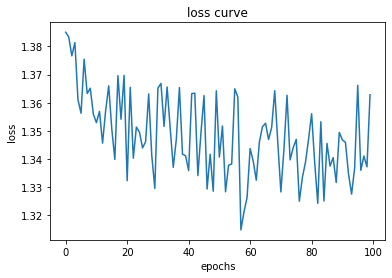

In [ ]:
import matplotlib.pyplot as plt
plt.plot(LOSS)
plt.title("loss curve")
plt.xlabel("epochs")
plt.ylabel("loss");